# NLP  

## Tokenization e lematizzazione

In questa fase rimuoviamo le stopwords, numeri e caratteri speciali e poniamo tutto in minuscolo. Infine viene effettuata la lemmatizzazione usanto un modello preaddestrato (SpaCy).

## Embedding

Sempre usando il modello preaddestrato di SpaCy, viene effettuata la conversione dei token in vettori di 300 dimensioni.

## Note



In [4]:
#Import da eseguire sempre
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import regex as re

from sklearn.manifold import TSNE


In [5]:
#circa 7min di esecuzione con modello già caricato

#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()

    #removing multiple spaces
    s = " ".join(s.split()).strip()

    #some manual corrections
    s = s.replace(' accino', ' vaccino')

    #lemmatization with spacy
    doc = nlp(s)
    return " ".join([token.lemma_ for token in doc if not token.is_stop]).strip()

def remove_stopwords(s):
    doc = nlp(s)
    return " ".join([token.text for token in doc if not token.is_stop]).strip()

'''
load_stopwords_list(file_path: str) -> list
    Load stopwords from a file containing one stopword per line.
'''
def load_stopwords_list(file_path = "data/it_stopwords_kaggle.txt"):
    with open(file_path, 'r') as f:
        return f.read().splitlines()

#carichiamo il modello
nlp = spacy.load("it_core_news_sm")

#load pandas dataframe
vax_df = pd.read_csv('data/posts_cleaned_it_only.csv')

#load stopwords and adding to the model
italian_stopwords = load_stopwords_list()
for stopword in italian_stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True


#selezioniamo solo la colonna clean_text
vax_df = vax_df['clean_text']

#applichiamo la funzione di pulizia
vax_df_cleaned = vax_df.apply(cleaner)
#è necessario applicare nuovamente la funzione per rimuovere le stopwords che sono state aggiunte dalla lemmatizzazione
vax_df_cleaned = vax_df_cleaned.apply(remove_stopwords)

#esportiamo il dataset pulito in formato csv 
vax_df_cleaned.to_csv('data/posts_ULTRAcleaned_it_only_spacy.csv', index=False)

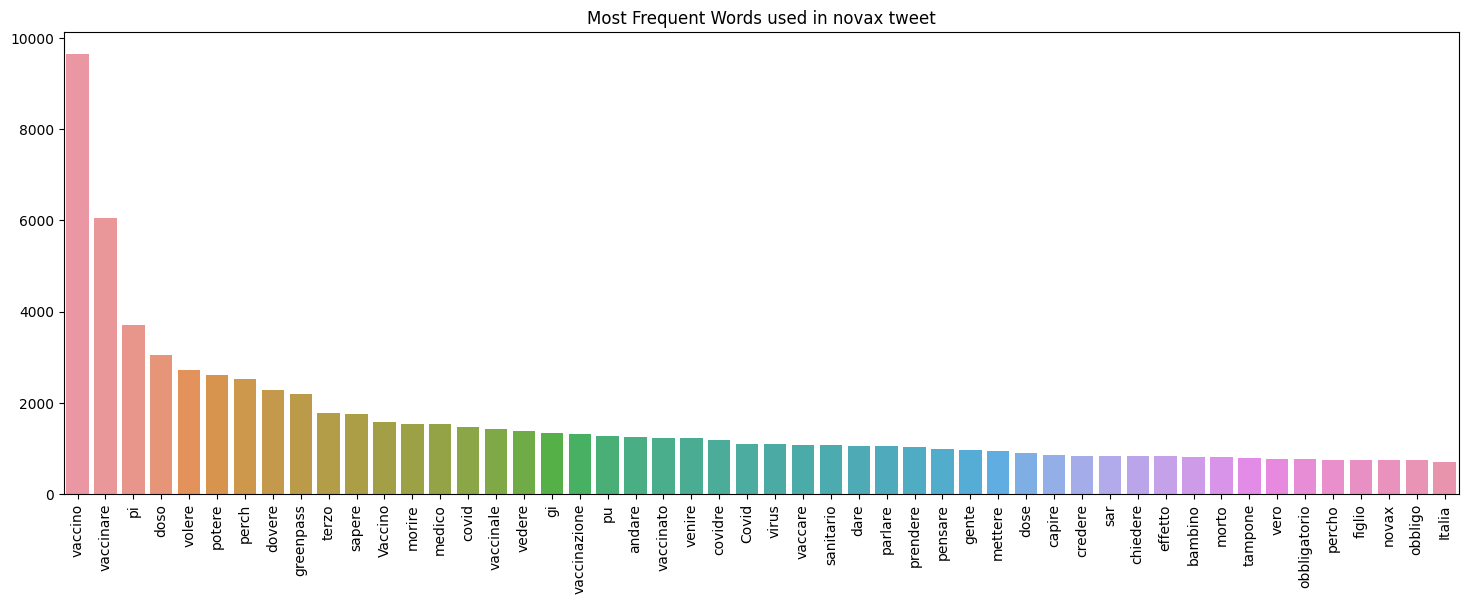

In [6]:
#analisi del dataset pulito 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#contiamo le parole
aggregate_counter = Counter()
for row in vax_df_cleaned:
    c = Counter(row.split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

#disegnamo i grafici
def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()


barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in novax tweet')

In [7]:
#vettorizzazione (embedding) del dataset pulito
import spacy
import pandas as pd

#carichiamo il modello
nlp = spacy.load("it_core_news_sm")

#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
vax_series = pd.read_csv('data/posts_ULTRAcleaned_it_only_spacy.csv')
vax_series.dropna(inplace=True)

#create a new column with the cleaned text dataframe with the vector representation of the text
vector_list = []
for x in vax_series["clean_text"]:
    vector = nlp(x).vector
    vector_list.append(vector)

#casting series to Datafram
vax_df = pd.DataFrame(vax_series)
#append vector column
vax_df['vector'] = vector_list

#esportiamo il dataframe pulito in formato csv 
vax_df.to_csv('data/post_it_cleaned_vectorized.csv', index=False)

In [8]:
#UNSUPervised learning
import pandas as pd
import numpy as np
#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
#IMPORTANTE la seconda colonna non è una stringa ma un array nmpy
vax_df = pd.read_csv('data/post_it_cleaned_vectorized.csv', dtype={ 'clean_text': str})
#trasformiamo la colonna vector in una lista di array numpy
vax_df["vector"] = vax_df["vector"].apply(lambda x: np.fromstring(x[1:-1], sep=' '))



In [14]:
test = pd.DataFrame(vax_df["vector"])
test.insert(0,'index_col', test.index)
#convert "vector" column from
#test["vector"] = test["vector"].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
type(test["vector"])

'''
for i in range(0, 19097-1):
  test["vector"][i] = np.array(test["vector"][i])
  continue
'''
test


,index_col,vector
0,0,"[3.7634609, 1.8319638, -0.43868357, 0.10894231..."
1,1,"[1.270329, 1.2720761, 0.74115956, -0.6334473, ..."
2,2,"[1.5351969, 1.4428324, 0.47180006, -1.3103138,..."
3,3,"[1.9856238, -0.01928503, 1.1070777, -0.9340384..."
4,4,"[1.6401534, 1.4979361, 1.7064584, 0.06242673, ..."
...,...,...
19092,19092,"[2.1769385, 0.67540425, 0.43965873, 0.10247028..."
19093,19093,"[0.94596297, 0.35412273, 1.7717986, -0.3631511..."
19094,19094,"[2.0460176, 0.86762, 0.6684806, -0.43744478, 0..."
19095,19095,"[1.8923752, 0.8902082, 1.0592839, -0.5389279, ..."


In [10]:
type(test["vector"][0])
array = test.to_numpy()
type (array)
array


array([[0, array([], dtype=float64)],
       [1, array([], dtype=float64)],
       [2, array([], dtype=float64)],
       ...,
       [19094, array([], dtype=float64)],
       [19095, array([], dtype=float64)],
       [19096, array([], dtype=float64)]], dtype=object)

In [11]:
#TODO: boh per me è rotto gli sto letteralmente dando un array e mi dice che è una sequenza

In [12]:
#Training the autoencoder
from sklearn.neural_network import MLPRegressor

#converto la lista di array numpy in un array numpy
#test = vax_df["vector"]

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(test, test)
predicted_vectors = auto_encoder.predict(test)

ValueError: setting an array element with a sequence.